# Import the necessary libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
#from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

### Load the data into Pandas dataframe

In [26]:
df = pd.read_csv('../input/trainedosha-data/TrainedOSHAData.csv',delimiter=',',encoding='latin-1')
df.head()

,Event Date,Abstract_Text,Event Description,Event Keywords,Construction End Use,Project Type,Degree_of_Injury,Nature_of_Injury,Part_of_Body,Event_Type,Environmental_Factor,Human_Factor,Task_Assigned
0,08-10-2017,"At 9:00 a.m. on August 10, 2017, an employee w...",EMPLOYEE'S FINGERS AMPUTATED WHILE OPERATING A...,"FINGER,MECHANICAL POWER PRESS,AMPUTATION,GUARD",,,Nonfatal,"Amputation, Crushing",Fingers,Caught in or between,Catch Point/Puncture Action,Other,Regularly Assigned
1,7/17/2017,"At 9:45 a.m. on July 17, 2017, an employee was...",EMPLOYEE'S FINGER IS CAUGHT IN DRILL AND IS AM...,"CAUGHT IN,DRIVE SHAFT,RESIDENTIAL CONSTRUCTION...",Other building,Alteration or rehabilitation,Nonfatal,Dislocation,Fingers,Caught in or between,Other,Position Inappropriate For Task,Regularly Assigned
2,6/30/2017,"At 7:30 a.m. on June 30, 2017, an employee was...",EMPLOYEE IS HOSPITALIZED AFTER BEING INJURED I...,"AMPUTATED,EXPLOSION,FIREWORKS",,,Nonfatal,Fire Burn,Hand,Other,Other,Malfunction In Securing/Warning Op,Not Regularly Assigned
3,6/30/2017,"At 2:00 p.m. on June 30, 2017, an employee was...",EMPLOYEE FALLS FROM ROOF AND IS INJURED,"RIB,ROOF,HEAD,FALL PROTECTION,FALL,COLLARBONE,...",Commercial building,Alteration or rehabilitation,Fatal,Serious Fall/Strike,Head,Fall (from elevation),Work-Surface/Facility-Layout Condition,Other,Regularly Assigned
4,6/23/2017,"At 12:20 p.m. on June 23, 2017, an employee wa...",EMPLOYEE IS STRUCK BY PLYWOOD WHILE UNLOADING ...,"STRUCK BY,TRUCK,BRAIN,NECK,FRACTURE,UNSTABLE LOAD",,,Nonfatal,"Bruising, Contusion",Neck,Struck-by,Overhead Moving/Falling Object Action,Insufficient/Lack/Housekeeping Program,Regularly Assigned


Drop the columns that are not required for the neural network.

In [27]:
df.drop(['Event Date'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4847 entries, 0 to 4846
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Abstract_Text         4847 non-null   object
 1   Event Description     4847 non-null   object
 2   Event Keywords        4847 non-null   object
 3   Construction End Use  4847 non-null   object
 4   Project Type          4847 non-null   object
 5   Degree_of_Injury      4847 non-null   object
 6   Nature_of_Injury      4845 non-null   object
 7   Part_of_Body          4845 non-null   object
 8   Event_Type            4845 non-null   object
 9   Environmental_Factor  4840 non-null   object
 10  Human_Factor          4840 non-null   object
 11  Task_Assigned         4847 non-null   object
dtypes: object(12)
memory usage: 454.5+ KB


## Degree of Injury

Fatal       2964
Nonfatal    1883
Name: Degree_of_Injury, dtype: int64


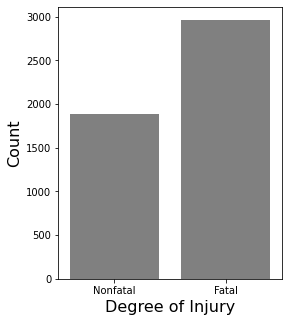

In [28]:
print(df['Degree_of_Injury'].value_counts())
plt.figure(figsize=(4,5))
sns.countplot(x=df.Degree_of_Injury, color='gray')
#plt.title('Degree of Injury', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlabel('Degree of Injury', fontsize=16)
plt.xticks();
plt.show()

* Create input and output vectors.
* Process the labels.

In [29]:
X = df.Abstract_Text
Y = df.Degree_of_Injury
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

Split into training and test data.

In [30]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3)

##### Process the data
* Tokenize the data and convert the text to sequences.
* Add padding to ensure that all the sequences have the same shape.
* There are many ways of taking the *max_len* and here an arbitrary length of 150 is chosen.

In [31]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

### RNN
Define the RNN structure.

In [32]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

Call the function and compile the model.

In [33]:
from keras import backend as K
#k.epsilon() is used to prevent division by zero error
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f2_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 5*((precision*recall)/(4*precision+recall+K.epsilon()))

In [34]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['acc', f2_m, precision_m, recall_m])
#model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['acc'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

Fit on the training data.

In [35]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
22/22 [==============================] - 8s 232ms/step - loss: 0.6138 - acc: 0.7339 - f2_m: 0.4077 - precision_m: 0.6402 - recall_m: 0.3839 - val_loss: 0.4371 - val_acc: 0.9028 - val_f2_m: 0.9122 - val_precision_m: 0.8429 - val_recall_m: 0.9318


Process the test set data.

In [36]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

Evaluate the model on the test set.

In [37]:
loss, accuracy, f2_score, precision, recall = model.evaluate(test_sequences_matrix,Y_test)
#loss, accuracy = model.evaluate(test_sequences_matrix,Y_test)

46/46 [==============================] - 2s 38ms/step - loss: 0.4394 - acc: 0.9155 - f2_m: 0.9212 - precision_m: 0.8469 - recall_m: 0.9450


In [38]:
#print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
print('Loss: %.3f' % loss) 
print('Accuracy: %.3f' % (accuracy*100))
print('F2 Score: %.3f' % (f2_score*100))
print('Precision: %.3f' % (precision*100))
print('Recall: %.3f' % (recall*100))

Loss: 0.439
Accuracy: 91.546
F2 Score: 92.118
Precision: 84.692
Recall: 94.502


## Frequency of Task Assigned

In [39]:
X = df.Abstract_Text
Y = df.Task_Assigned
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3)